In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import time as t
import cv2
from torchvision import utils
import tensorflow as tf
from itertools import chain
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import re

import seaborn as sns
from sklearn.manifold import TSNE

from utils import * 

In [3]:
def extract_base_name(filepath):
    return re.sub(r'(-[a-zA-Z0-9]+)?\.\w+$', '', os.path.basename(filepath))

In [176]:
# Dataset

trainval_folder = 'data\\PRPD_dataset\\TrainVal'
test_folder = 'data\\PRPD_dataset\\Test'

def get_dataset(path, split=''):
    images_path = []
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            path = os.path.join(dirpath, file)
            motor = os.path.basename(dirpath)
            defect = os.path.basename(os.path.dirname(dirpath))
            images_path.append((path, motor, defect, split))
    return images_path

trainval_path = os.path.join(os.path.dirname(os.getcwd()), trainval_folder)
test_path = os.path.join(os.path.dirname(os.getcwd()), test_folder)

classes = os.listdir(trainval_path)
print('Defects: {}'.format(classes))

trainval_ds = get_dataset(trainval_path, split='Train-val')
test_df = get_dataset(test_path, split='Test')

# Create pandas dataframe
df = pd.DataFrame(trainval_ds+test_df, columns=['Filename', 'Motor', 'Defect', 'Split'])
df['Class'], unique_labels = pd.factorize(df['Defect'])

Defects: ['corona', 'internal', 'surface']


In [97]:
df.head()

Filename  Motor  Defect  \
0  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
1  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
2  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
3  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
4  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   

       Split  Class  
0  Train-val      0  
1  Train-val      0  
2  Train-val      0  
3  Train-val      0  
4  Train-val      0

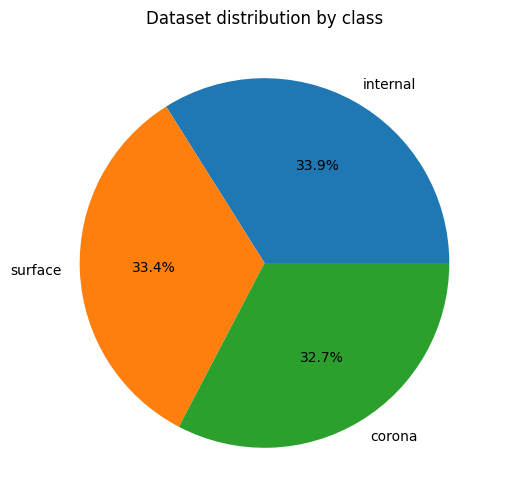

In [40]:
plt.figure(figsize=(6,6))
df.Defect.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Dataset distribution by class')
plt.show()

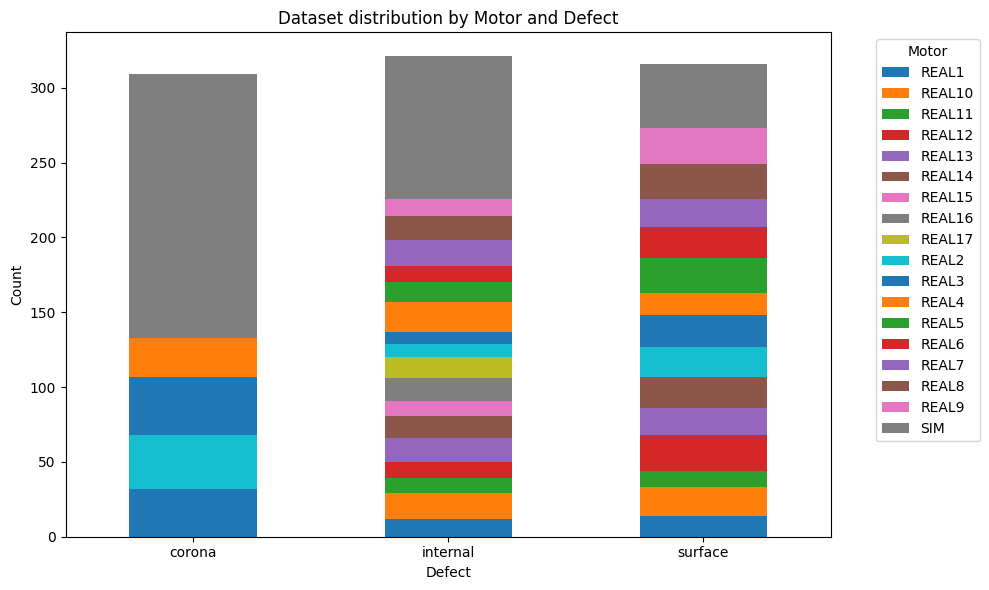

In [44]:
# Count defects grouped by motor
defect_motor_counts = df.groupby('Defect')['Motor'].value_counts().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size
defect_motor_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Dataset distribution by Motor and Defect')
plt.xlabel('Defect')
plt.ylabel('Count')
plt.legend(title='Motor', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.xticks(rotation=0)  # Optional: rotate x-axis labels
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [56]:
class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.filenames = self.df['Filename'].values
        self.labels = self.df['Class'].values
        self.defect = self.df['Defect'].values
        self.images = np.zeros((len(self.labels), 128, 165, 3), dtype= np.uint8)
        self.transform = transform
        self.getImages()

    def getImages(self):
        for idx, filename in enumerate(self.filenames):
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (165, 128), interpolation = cv2.INTER_AREA)
            self.images[idx] = img

    def toTensor(self, data):
        image = data.transpose((2,0,1))
        return torch.from_numpy(image)

    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())
    
    def __getitem__(self, idx):
        x = self.normalize(self.images[idx])
        x = self.toTensor(x)
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return len(self.filenames)

In [57]:
def min_max_normalize(images):
    # Ensure the input is a numpy array
    images = np.array(images, dtype=np.float32)
    
    # Initialize an array for normalized images
    normalized_images = np.empty_like(images)
    
    # Normalize each image individually
    for i in range(images.shape[0]):
        img = images[i]
        min_val = np.min(img)
        max_val = np.max(img)
        normalized_images[i] = (img - min_val) / (max_val - min_val)
    
    return normalized_images

In [58]:
transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True)])
dataset = ImageDataset(df, transform=transform)

## PCA

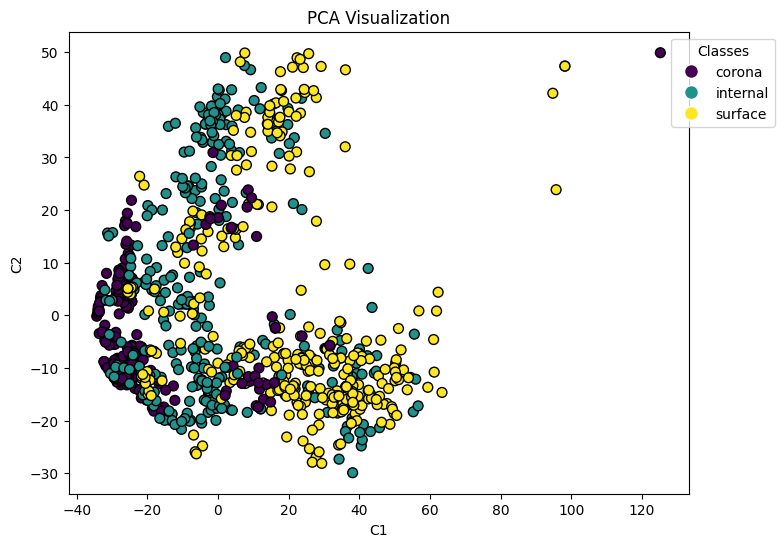

In [64]:
from sklearn.decomposition import PCA

# Apply PCA
num_images = len(dataset)
X = min_max_normalize(dataset.images)
X_flat = X.reshape(num_images, -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dataset.labels, cmap='viridis', edgecolor='k', s=50)

# Create a legend
unique_labels = np.unique(dataset.labels)
unique_defects = np.unique(dataset.defect)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in unique_labels]

plt.legend(handles, unique_defects , title='Classes', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('PCA Visualization')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

## t-SNE

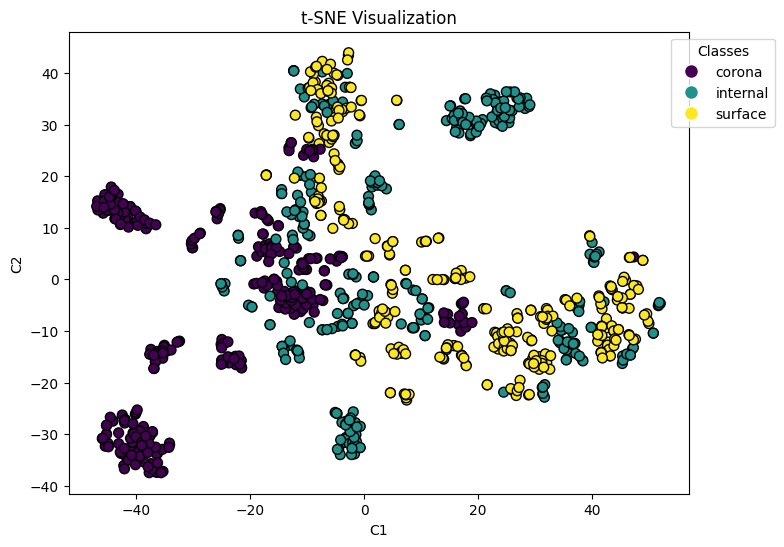

In [76]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Plot t-SNE
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dataset.labels, cmap='viridis', edgecolor='k', s=50)

# Create a legend
unique_labels = np.unique(dataset.labels)
unique_defects = np.unique(dataset.defect)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in unique_labels]

plt.legend(handles, unique_defects , title='Classes', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('t-SNE Visualization')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

## UMAP

C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


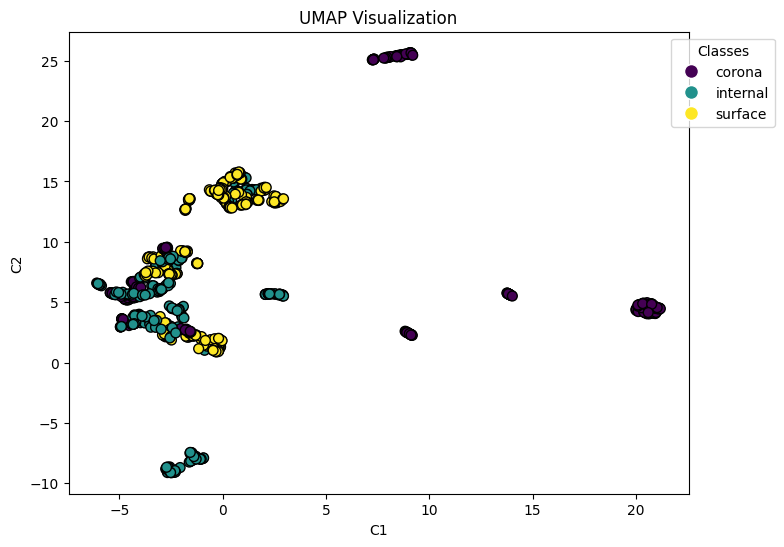

In [77]:
import umap

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_flat)

# Plot UMAP
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=dataset.labels, cmap='viridis', edgecolor='k', s=50)

# Create a legend
unique_labels = np.unique(dataset.labels)
unique_defects = np.unique(dataset.defect)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in unique_labels]

plt.legend(handles, unique_defects , title='Classes', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('UMAP Visualization')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

In [160]:
from skimage.feature import graycomatrix, graycoprops

def get_texture_properties(image):
    distances = [1,2,3,4]  # pixel distance
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # directions (0°, 45°, 90°, 135°)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256)

    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    asm = graycoprops(glcm, 'ASM')

    return (np.mean(contrast), np.mean(correlation), np.mean(energy), np.mean(homogeneity), np.mean(dissimilarity), np.mean(asm))

In [177]:
from scipy.stats import skew, kurtosis

texture_features = []

for idx, image in enumerate(dataset.images):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    glcm_features = get_texture_properties(gray)
    # Calculate statistics for the grayscale image
    just_gray = gray[gray != 0]
    mean = np.mean(just_gray)
    var  = np.var(just_gray)
    skewness = skew(just_gray.flatten())
    kurt = kurtosis(just_gray.flatten())
    
    texture_features.append({'Filename': dataset.filenames[idx], 'Contrast': glcm_features[0], 
                             'Correlation': glcm_features[1], 'Energy': glcm_features[2],
                             'Homogeneity': glcm_features[3], 'Dissimilarity': glcm_features[4],
                             'ASM': glcm_features[5], 'Mean': mean, 
                             'Variance': var, 'Skewness': skewness,
                             'Kurtosis': kurt})

# Convert the list of dictionaries to a DataFrame
glcm_df = pd.DataFrame(texture_features)
glcm_df.set_index('Filename', inplace=True)  # Set filename as the index to match original_df

In [178]:
df = df.join(glcm_df, on='Filename', how='left')

In [179]:
df.head()

Filename  Motor  Defect  \
0  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
1  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
2  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
3  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   
4  C:\Users\jazg2\OneDrive\Documents\Pesquisa_Mes...  REAL2  corona   

       Split  Class    Contrast  Correlation    Energy  Homogeneity  \
0  Train-val      0  496.554148     0.758370  0.946626     0.947604   
1  Train-val      0  420.033899     0.722525  0.951741     0.952563   
2  Train-val      0  525.953812     0.763824  0.940458     0.941588   
3  Train-val      0  388.868577     0.721238  0.955201     0.955845   
4  Train-val      0  364.198675     0.731182  0.954168     0.955039   

   Dissimilarity       ASM        Mean     Variance  Skewness  Kurtosis  
0       3.957528  0.896124  140.764192  4308.933478 -0.629142 -0.896629  
1       3.513057  0.905837  124.705160  4312.773020 -0.388756 -1.108421  
2       4.259785  0.884485  137.029126  4578.599152 -0.590478 -0.964382  
3       3.281155  0.912432  125.724230  4118.454072 -0.395278 -1.089167  
4       3.161891  0.910456  119.644993  4349.292696 -0.329122 -1.182020

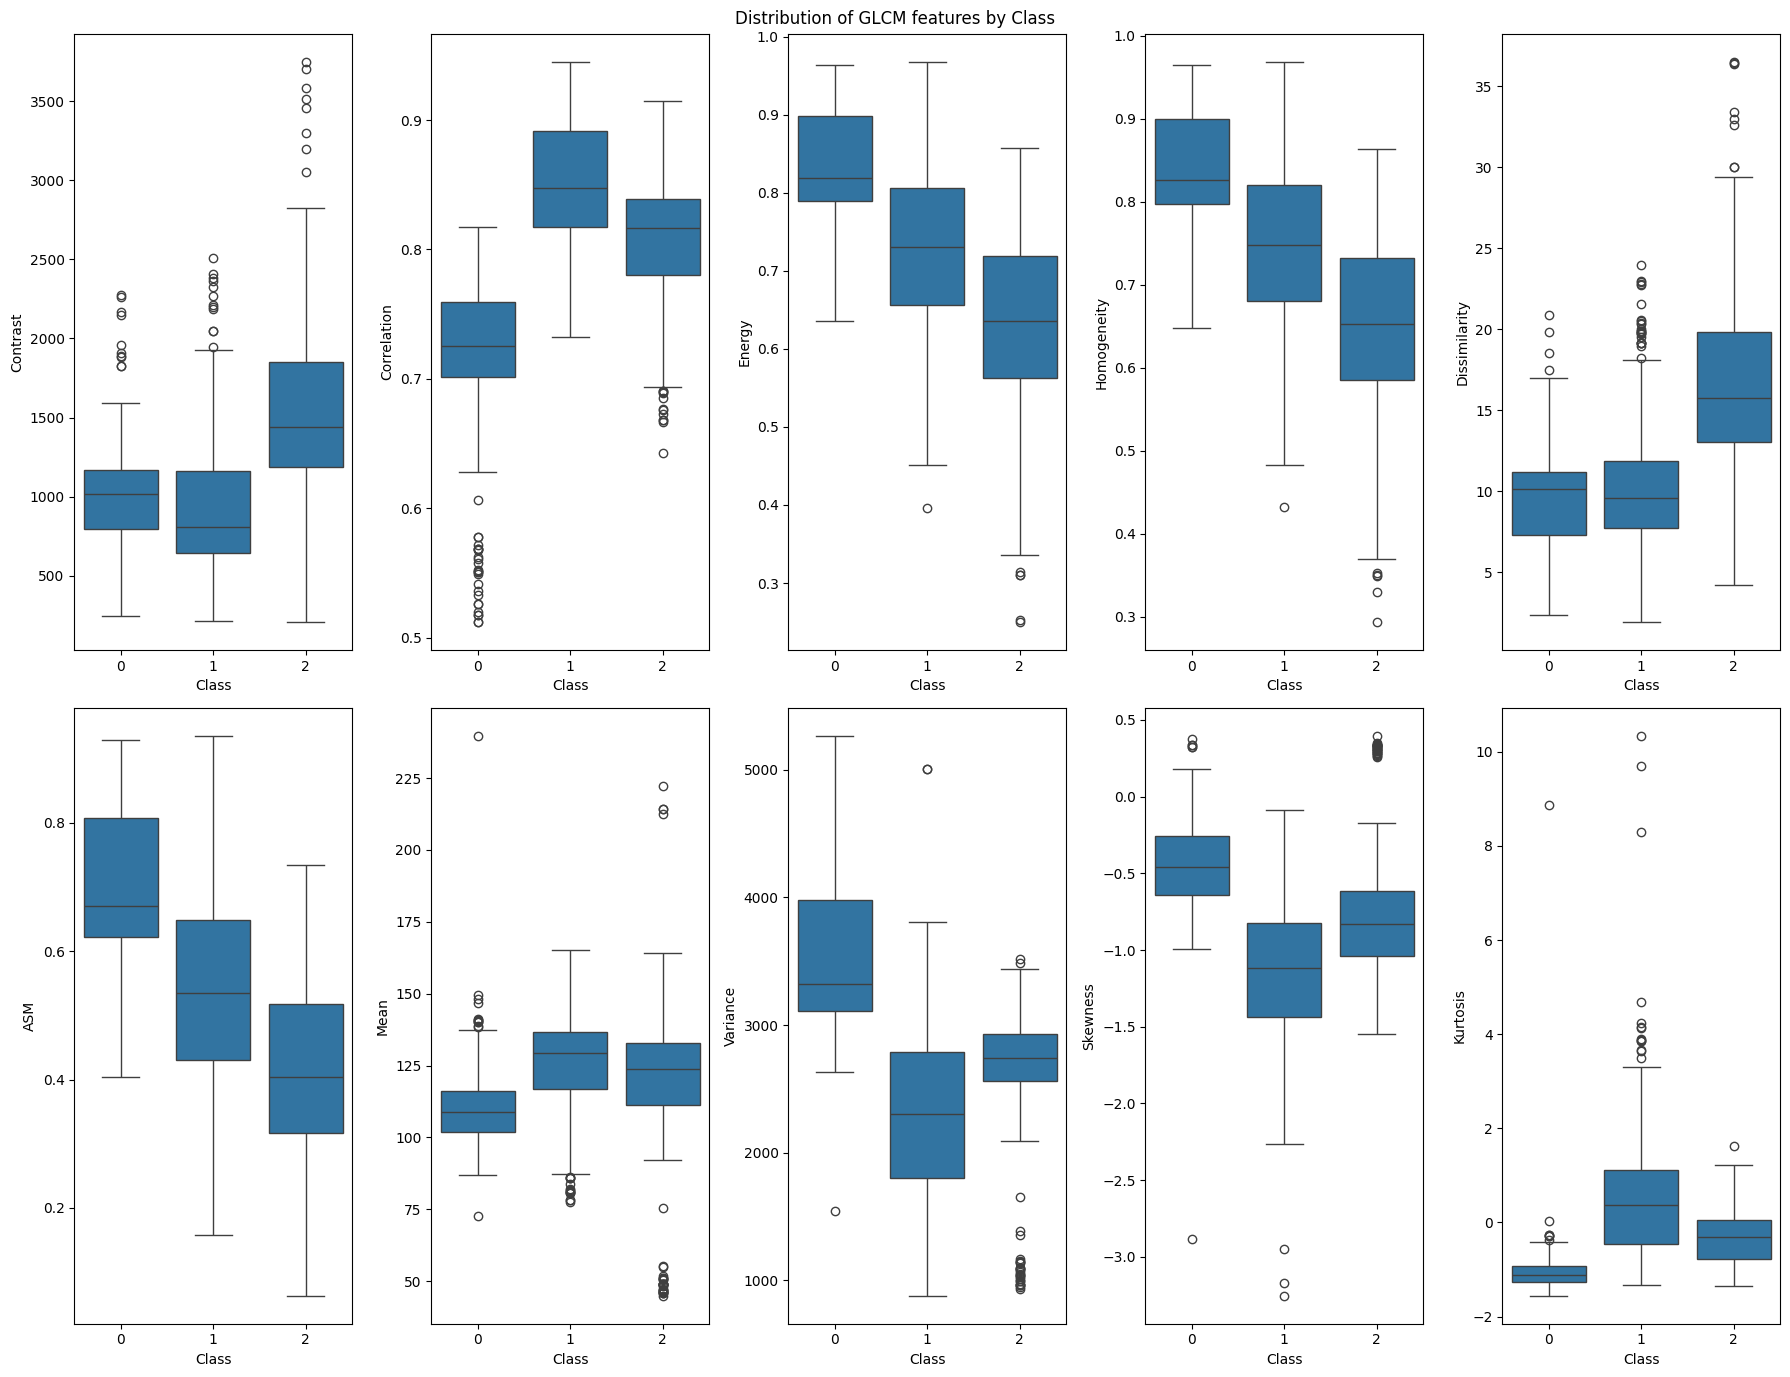

In [180]:
plt.figure(figsize=(18, 14))

features = ['Contrast', 'Correlation', 'Energy', 'Homogeneity',
            'Dissimilarity', 'ASM', 'Mean', 'Variance',
            'Skewness', 'Kurtosis']

for idx, feature in enumerate(features):
    plt.subplot(2,5,idx+1)
    sns.boxplot(x='Class', y=feature, data=df)
plt.suptitle('Distribution of GLCM features by Class')
plt.tight_layout()
plt.show()

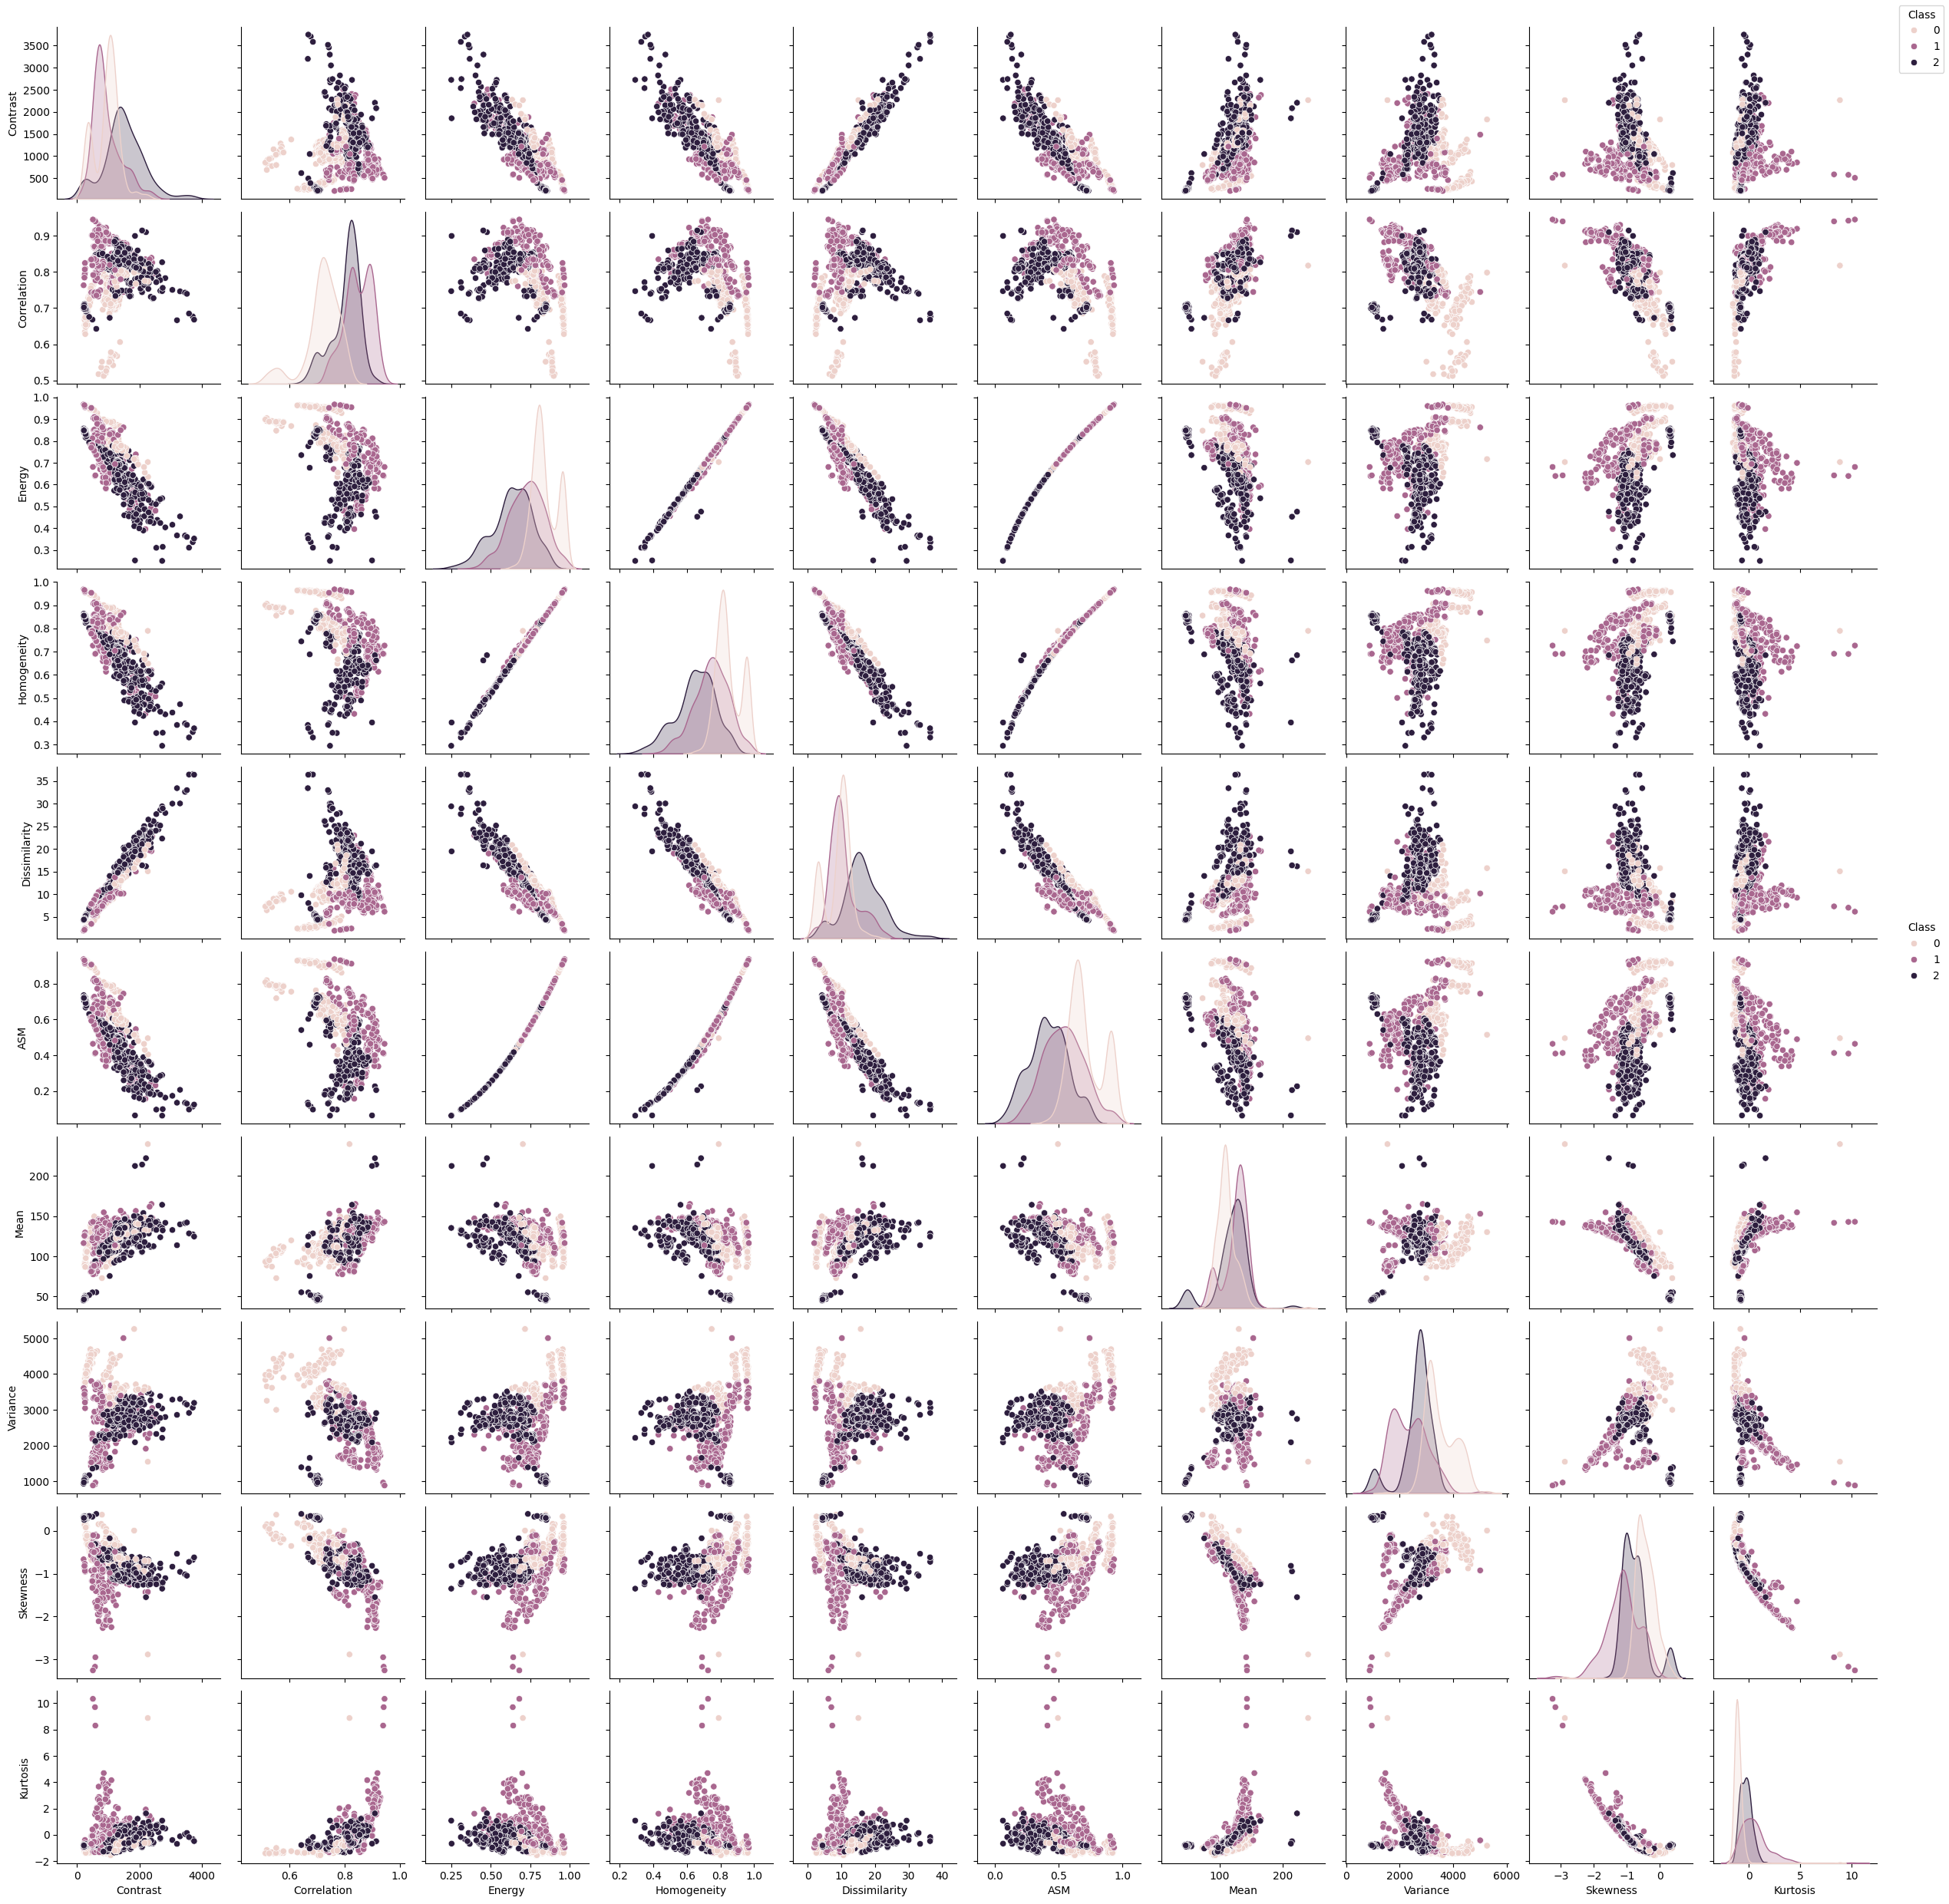

In [181]:
pairplot = sns.pairplot(df, hue='Class')
for ax in pairplot.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        pairplot.fig.legend(handles, labels, loc='upper right', title='Class')
        break
plt.show()

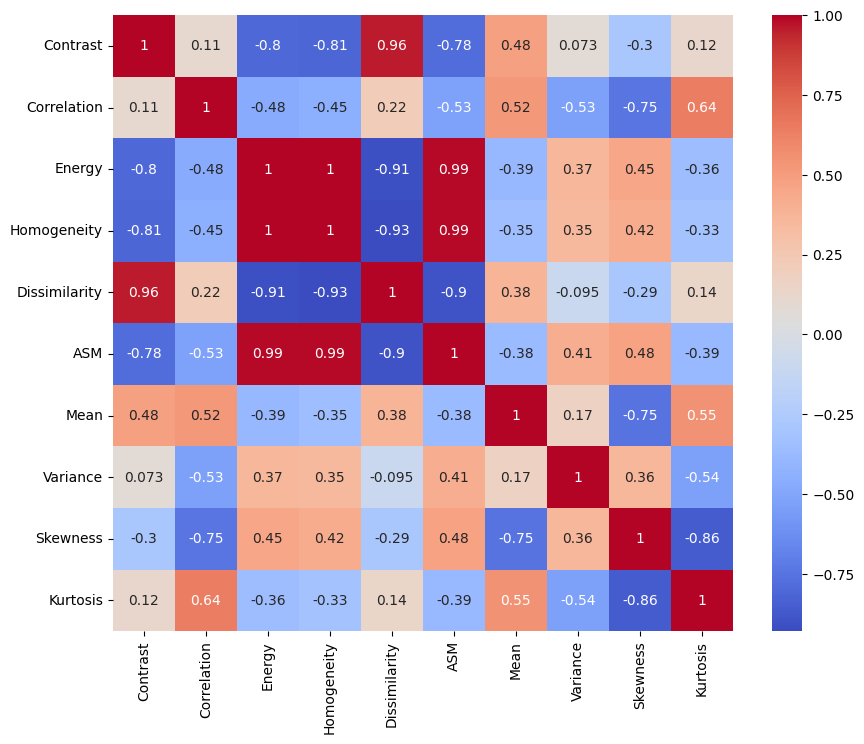

In [182]:
corr_matrix = df[features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

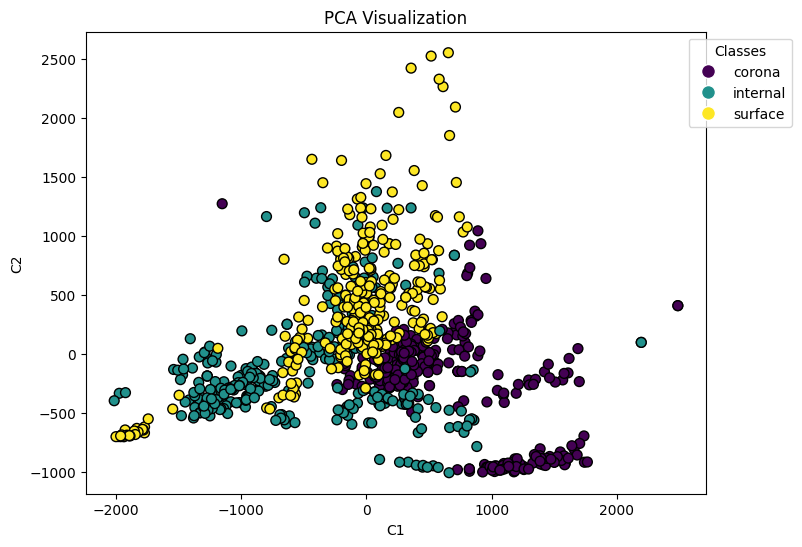

In [183]:
glcm = df[features]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(glcm.values)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dataset.labels, cmap='viridis', edgecolor='k', s=50)

# Create a legend
unique_labels = np.unique(dataset.labels)
unique_defects = np.unique(dataset.defect)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in unique_labels]

plt.legend(handles, unique_defects , title='Classes', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('PCA Visualization')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

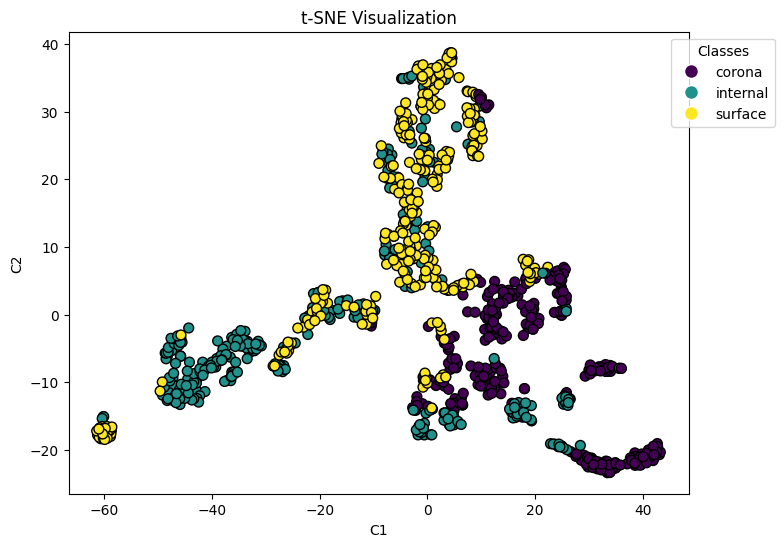

In [184]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(glcm.values)

# Plot t-SNE
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dataset.labels, cmap='viridis', edgecolor='k', s=50)

# Create a legend
unique_labels = np.unique(dataset.labels)
unique_defects = np.unique(dataset.defect)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in unique_labels]

plt.legend(handles, unique_defects , title='Classes', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('t-SNE Visualization')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


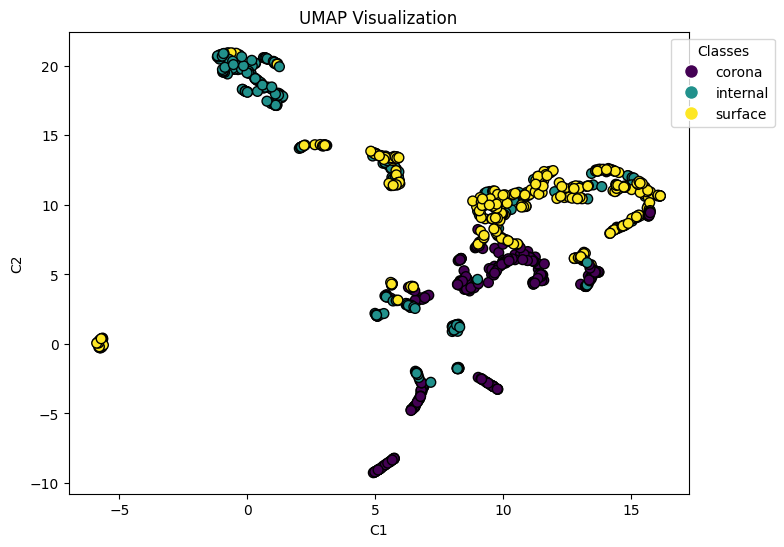

In [185]:
# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(glcm)

# Plot UMAP
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=dataset.labels, cmap='viridis', edgecolor='k', s=50)

# Create a legend
unique_labels = np.unique(dataset.labels)
unique_defects = np.unique(dataset.defect)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in unique_labels]

plt.legend(handles, unique_defects , title='Classes', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('UMAP Visualization')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()